In [1]:
import pandas as pd #'version 1.2.4'
import numpy as np #'version 1.21.0'
from basico import * #'version 0.36'
from scipy.optimize import minimize #'version 1.10.0'
import random
import matplotlib.pyplot as plt #'version 3.3.4'


replicates = 100
path = !pwd
path = path[0]

In [2]:
# define the number of cores to be used
# this code is commented because to prevent overloading and crashing computers. This code was run using AWS cloud computing.

# par_cores = 110 
# import ipyparallel as ipp # version 8.4.1
# cluster = ipp.Cluster(n=par_cores)
# cluster.start_cluster_sync()
# rc = cluster.connect_client_sync()
# rc.wait_for_engines(par_cores)
# dview = rc[0:par_cores] # for first tests

Starting 110 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


 65%|######4   | 71/110 [00:00<?, ?engine/s]

In [ ]:

def gen_random_guess(x): # function for generating a random start position for the parameter search
    guess = [0] * len(x) # make a list the same length as the given parameters
    for i in range(len(guess)):
        guess[i] = random.uniform(-10,-1) # select random value from this distribution
        guess[i] = 2**guess[i]
    return guess


In [6]:
# define the path for the models and the variant names then combine them
mod_path =path + "/Models/" 
files =  ["NMGPL_Model.xml", "NPMGL_Model.xml", "NMPGL_Model.xml", "NGPML_Model.xml", "NGMPL_Model.xml"] # ,"NMPGL_Model.xml", "NGMPL_Model.xml", "NGPML_Model.xml"]
models = [mod_path + m for m in files]

In [7]:
# define the parameters that will be fit independently. These are the binding rates
pars_to_fit = [ "Virion_Budding", "Virion_Assembly", "transcriptional_silencing",  "negative_strand_l_binding", "negative_strand_p_binding", "negative_strand_encapsidation", "positive_strand_encapsidation"]


In [8]:
# load one of the models in and separate reactions based on whether they are transcription reactions
# Genome synthesis reactions, or degradation reactions. 
# degredation reactions are split on whether they are genome, protein, or mRNA degradation reactions
mod = load_model(models[0])
set_current_model(mod)
reactions  = np.array(get_reaction_parameters()["reaction"])
transcription_reactions = reactions[["transcription_" in react for react in reactions]]
replication_reactions = reactions[["synthesis_" in react for react in reactions]]
deg_rs = reactions[["degradation" in react for react in reactions]]
genome_deg_rs = deg_rs[["sg" in react for react in deg_rs]]
deg_rs = deg_rs[((np.array(["sg" in react for react in deg_rs])-1) *-1) == 1]
mRNA_deg_rs = deg_rs[["m" in react for react in deg_rs]]
deg_rs = deg_rs[((np.array(["m" in react for react in deg_rs])-1) *-1) == 1]
prot_deg_rs = deg_rs


In [10]:
# load in models
models_loaded = []
for tmod in models:
    print(tmod)
    mod = basico.load_model(tmod)
    models_loaded.append(mod)

/Users/connorking/Desktop/PhD/Models/VSV/Paper_time/Fit_Parameter_Variants/Models/NMGPL_Model.xml
/Users/connorking/Desktop/PhD/Models/VSV/Paper_time/Fit_Parameter_Variants/Models/NPMGL_Model.xml
/Users/connorking/Desktop/PhD/Models/VSV/Paper_time/Fit_Parameter_Variants/Models/NMPGL_Model.xml
/Users/connorking/Desktop/PhD/Models/VSV/Paper_time/Fit_Parameter_Variants/Models/NGPML_Model.xml
/Users/connorking/Desktop/PhD/Models/VSV/Paper_time/Fit_Parameter_Variants/Models/NGMPL_Model.xml


In [11]:
# record the current values of the reactions that will be adjusted as a unit
# this is important because we will be updating the model reaction rates iteratively
# this would be problematic with how we are adjusting the reaction rates.
rep_rates = []
tran_rates = []
genome_deg_rates = []
mRNA_deg_rates = []
prot_deg_rates = []
for i, model in enumerate(models_loaded):
    basico.set_current_model(model)
    ks = np.array(get_reaction_parameters()["value"])
    tr = ks[[react in transcription_reactions for react in reactions]]
    rr = ks[[react in replication_reactions for react in reactions]]
    gdr = ks[[react in genome_deg_rs for react in reactions]]
    mdr = ks[[react in mRNA_deg_rs for react in reactions]]
    pdr = ks[[react in prot_deg_rs for react in reactions]]
    
    
    
    tran_rates.append( tr )
    rep_rates.append( rr)
    genome_deg_rates.append( gdr )
    mRNA_deg_rates.append( mdr)
    prot_deg_rates.append( pdr )
    

In [12]:
data = np.array([4347, 2087, 2348, 1304, 3957]) # observed mean virions produced by variants seen in literature

In [13]:

# define the function that will be parallelized 
def parallelization(ins):
    # import packages
    import basico 
    from scipy.optimize import minimize
    import numpy as np
    # define the objective function
    def obj_func(x):
        preds = np.zeros(len(models_loaded))
        # iterate through the models
        for i, model in enumerate(models_loaded):
            
            basico.set_current_model(model)
            
            # adjust the reaction rates that will be asjusted as a unit
            tr = tran_rates[i]/x[0]
            rr = rep_rates[i]/x[1]
            gdr = genome_deg_rates[i]/x[2]
            mdr = mRNA_deg_rates[i]/x[3]
            pdr = prot_deg_rates[i]/x[4]            
            
            # make the full list of reaction names and full list of new parameters
            reactions = list(genome_deg_rs) + list(mRNA_deg_rs) + list(prot_deg_rs) + list(replication_reactions) + list(transcription_reactions) + pars_to_fit
            params = list(gdr) + list(mdr) + list(pdr) + list(rr) + list(tr) + list(x[5:])
            # now change the reaction rates
            for m, param_name in enumerate(reactions):
                basico.set_reaction(param_name, mapping={"k1": params[m]})
            # simulate the model. If an error occurs set the prediction value to infinity
            try:
                tc = basico.run_time_course(duration=57000, start_time=0, stepsize=1000, method="LSODA")
                preds[i] = tc["V"].loc[57000]
            except:
                preds[i] = np.inf
        # calculate and return the MSE
        test = np.mean((preds - data)**2)
        print(test)
        del m, preds, tc
        return test
    
    # unpack the inputs of the parallelization function
    guess, models,  data, path, pars_to_fit, rep_rates, tran_rates, genome_deg_rates ,mRNA_deg_rates, prot_deg_rates ,  replication_reactions, transcription_reactions, genome_deg_rs, mRNA_deg_rs, prot_deg_rs = ins
    models_loaded = []
    # load models
    for tmod in models:
        mod = basico.load_model(tmod)
        models_loaded.append(mod) # load base model in
    del tmod
    # fit the model
    res = minimize(obj_func, guess, method = 'Nelder-Mead', tol = 10000, options = {"maxiter" : 600}) # perform optimization
    del models_loaded
    
    del guess, models,  data, path, pars_to_fit
    # return the results of fitting
    return res


In [15]:
# make the list of parallelzation inputs with randomized starting positions for reaction rates
parallelization_list = [[models, data, path, pars_to_fit,rep_rates,tran_rates,     
    genome_deg_rates,
    mRNA_deg_rates,
    prot_deg_rates, 
    replication_reactions,
    transcription_reactions,
    genome_deg_rs,
    mRNA_deg_rs,
    prot_deg_rs]] * replicates
parallelization_list = [[[1,1,1,1,1] + gen_random_guess(pars_to_fit) ] + par_lst for par_lst in parallelization_list]

In [16]:
# parallelize the optimizations
ar_map = dview.map_async(parallelization, parallelization_list)
ar_map.wait_interactive()
ar_map = ar_map.get()

parallelization:   0%|          | 0/100 [00:00<?, ?tasks/s]

In [ ]:
# update the parameters to include the other parameters fit as a unit.
pars_df = ["Transcription Rates", "Genome/Antigenome Synthesis Rates", "Genome/Antigenome Degradation Rates", "mRNA Degradation Rates", "Protein Degradation Rates"] + pars_to_fit

In [24]:
# unpack the results of the optimizations and add to lists
functions_outputs = []
parameter_values = []
parameter_names = []
tolerance = []
maxiter = []
num_iter = []
for x in ar_map:
    functions_outputs.append(x.fun)
    num_iter.append(x.nit)
    parameter_values.append(x.x)
    parameter_names.append(pars_df)
    tolerance.append(10000)
    maxiter.append(600)


In [25]:
# make datafram and to hold the data

df = pd.DataFrame([functions_outputs, parameter_values, parameter_names, tolerance, maxiter, num_iter]).T
df.columns = ["obj function output", "parameter values", "parameter names", "tolerance", "maxiter", "number of iterations"]


In [28]:
df.to_csv("vsv_fits_v1_2023_06_06.csv") # save data 

In [4]:
df = pd.read_csv("vsv_fits_v1_2023_06_06.csv", index_col=0) # load

In [17]:
# select the parameters that resulted in the best fit and process the string into a list

best_fit = df[df["obj function output"] ==  np.min(df["obj function output"])] 
best_fit = list(best_fit["parameter values"])[0]
best_fit = best_fit.replace("[", "").replace("]", "").replace("\n", "").replace(" ", ",").split(",")
best_fit = [float(x) for x in best_fit]

In [22]:
# define the path for the models and the variant names then combine them
mod_path =path + "/Models/" 
files =  ["NMGPL_Model.xml", "NPMGL_Model.xml", "NMPGL_Model.xml", "NGPML_Model.xml", "NGMPL_Model.xml"] # ,"NMPGL_Model.xml", "NGMPL_Model.xml", "NGPML_Model.xml"]
models = [mod_path + m for m in files]

4190.876394467171
2474.5220798240744
2688.0154449857528
2122.8975434412714
3029.918399034962


(0.0, 4500.0)

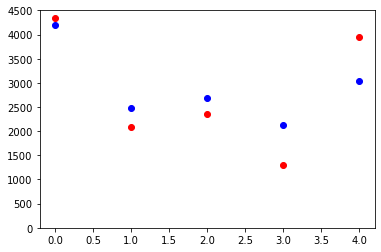

In [23]:
# update parameters and save the new models

data = np.array([4347, 2087, 2348, 1304, 3957])
preds = np.zeros(len(models_loaded))

for i, model in enumerate(models_loaded):
    basico.set_current_model(model)

    tr = tran_rates[i]/best_fit[0]
    rr = rep_rates[i]/best_fit[1]
    gdr = genome_deg_rates[i]/best_fit[2]
    mdr = mRNA_deg_rates[i]/best_fit[3]
    pdr = prot_deg_rates[i]/best_fit[4]            

    reactions = list(genome_deg_rs) + list(mRNA_deg_rs) + list(prot_deg_rs) + list(replication_reactions) + list(transcription_reactions) + pars_to_fit
    params = list(gdr) + list(mdr) + list(pdr) + list(rr) + list(tr) + list(best_fit[5:])

    for m, param_name in enumerate(reactions):
        basico.set_reaction(param_name, mapping={"k1": params[m]})

    tc = basico.run_time_course(duration=57000, start_time=0, stepsize=1000, method="LSODA")
    print(tc["V"].loc[57000])
    preds[i] = tc["V"].loc[57000]
    new_mod = models[i].split(".")[0] + "_v2.xml"
    save_model(new_mod)
    
    
plt.scatter(range(len(preds)),preds, color = "blue")

plt.scatter(range(len(data)),data, color = "red")
plt.ylim(0,4500)